# devlog 2024-02-14

The "Z Virus" scenario -- a workshop to build understanding of epymorph and its systems.

0. Context: we're doing a deep dive on one possible scenario, but remember that other scenarios are also possible! We will not see every feature, but focus deeply on the features related to our scenario.
1. Pose the scenario. We are epidemiologists modeling the behavior of the "Z Virus": a human-to-human, airborne illness.
    - What are we going to need to specify for our task?
    - GEO: We are working with a number of county public health departments across the southwest, so our modeling will focus there.
    - IPM: We don't know everything about this virus yet, so we're guessing about the parameters. We assume it can be modeled as SEIRV. (If we have time we can experiment with sim parameter values.)
    - MM: We don't have a strong opinion about how people move around, so we may want to try a few basic things.
    - Most importantly, how impactful are possible mitigations? Contact reduction. Movement restrictions. Vaccines.
2. Pre-built IPM. (Assume the participants have experienced basic IPM construction.)
    - Show the SEIRV IPM.
    - Together, draw the box and arrow plot.
    - Discuss interpretation of the rate expressions.
    - Understand poisson processes.
3. Movement. What are our options? (Choose one from library. Build one. What data do we need?) Let's pick one to start.
4. GEO. We know what data we need, now let's go get it.
    - Write a geo spec.
    - Run it.
    - Inspect some values.
    - Cache the results.
5. Initialization.
    - What is the job of the initializer? What if we didn't seed an infection?
    - What are some reasonable ways to initialize the sim?
    - What does epymorph have built-in?
6. Set up the sim and input our (basic) starting parameters.
    - Mention time frame and RNG.
7. Experiment!
    - Run and draw an infection plot.
    - What is the role of randomness in the results? (Which plot is _right_?)
    - Mess with some params, like movement_factor, and compare plots.
        - Movement: high, medium, very low
        - Vaccine: none, some, lots
    - Inspect the output object.
        - What are the shapes of the results and why? (esp re tau steps)
        - Drilling down: see data for Maricopa County
            - How do we find Maricopa County?
            - What is the infection prevalence in Maricopa County? (custom plot! compartment 1)
            - What about the new-infections curve? (change plot, event 0)
            - Understand how incidence is time-step-dependent but not prevalence.
            - Re-plot with daily incidence.
    - Then calculate some hard numbers:
        - Value of peak infection per county
        - Date of peak infection per county (Tyler says "use numpy argmax")
        - Total overall infection
        - Time series of infection, aggregated by state
    - What about a vaccine distribution model which takes into account how urbanized an area is?
        - IPM functional param!
        - And how can we inspect the number of vaccinated over time?

In [1]:
from sympy import Max

from epymorph.compartment_model import *


def z_virus_ipm() -> CompartmentModel:
    symbols = create_symbols(
        compartments=[
            compartment('S'),  # 0
            compartment('E'),  # 1
            compartment('I'),  # 2
            compartment('R'),  # 3
            compartment('V'),  # 4
        ],
        attributes=[
            param('beta', shape=Shapes.S, dtype=float),
            param('sigma', shape=Shapes.S, dtype=float),
            param('gamma', shape=Shapes.S, dtype=float),
            param('alpha', shape=Shapes.TxN, dtype=float),
        ],
    )

    [S, E, I, R, V] = symbols.compartment_symbols
    [beta, sigma, gamma, alpha] = symbols.attribute_symbols

    N = Max(1, S + E + I + R + V)

    return create_model(
        symbols=symbols,
        transitions=[
            edge(S, E, rate=beta * S * I / N),  # 0
            edge(E, I, rate=sigma * E),  # 1
            edge(I, R, rate=gamma * I),  # 2
            edge(S, V, rate=alpha),  # 3
        ]
    )

In [2]:
from epymorph.movement.parser import parse_movement_spec

commuter_mm = parse_movement_spec("""\
# == Simple Commuter Movement ==
# A simplified commuter model based on a commuting matrix.
# Breaks the day up into two steps:
#  1) the work day (tau=1/3), and
#  2) time at home (tau=2/3)
# The number of commuters is poisson-distributed, using the data as the expectation.
# However the expectation can be scaled (up or down) by a parameter `movement_factor`.
# Parameters:
#  - geo['commuters']: an NxN matrix of integers
#  - params['movement_factor']: a T-length array of floats

[move-steps: per-day=2; duration=[1/3, 2/3]]

[predef: function = 
def commuter_predef():
    # Zero-out self-commuting.
    commuters = geo['commuters'].copy()
    np.fill_diagonal(commuters, 0)
    return { 'commuters': commuters }
]

# Commuter movement
[mtype: days=all; leave=1; duration=0d; return=2; function=
def commuters(t):
    expected = predef['commuters'] * params['movement_factor']
    return np.poisson(expected)
]
""")

In [3]:
import numpy as np

from epymorph.data_shape import Shapes
from epymorph.error import GeoValidationException
from epymorph.geo import *
from epymorph.geo.adrio import adrio_maker_library
from epymorph.geo.adrio.census.adrio_census import CensusGeography, Granularity
from epymorph.geo.cache import save_to_cache
from epymorph.geo.dynamic import DynamicGeo


def create_geo():
    geo_spec = DynamicGeoSpec(
        attributes=[
            AttribDef('label', np.str_, Shapes.N),
            AttribDef('geoid', np.str_, Shapes.N),
            AttribDef('centroid', CentroidDType, Shapes.N),
            AttribDef('population', np.int64, Shapes.N),
            AttribDef('pop_density_km2', np.float64, Shapes.N),
            AttribDef('commuters', np.int64, Shapes.NxN),
        ],
        time_period=Year(2020),
        geography=CensusGeography(
            granularity=Granularity.COUNTY,
            filter={
                'state': ['04', '35', '32', '08', '49'],  # AZ, NM, NV, CO, UT
                'county': ['*'],
                'tract': ['*'],
                'block group': ['*'],
            },
        ),
        source={
            'label': 'Census:name',
            'geoid': 'Census',
            'centroid': 'Census',
            'population': 'Census',
            'pop_density_km2': 'Census',
            'commuters': 'Census',
        },
    )

    try:
        geo = DynamicGeo.from_library(geo_spec, adrio_maker_library)
        geo.validate()
        save_to_cache(geo, 'devlog-20240214')
    except GeoValidationException as e:
        print(e.pretty())


# create_geo()

In [4]:
from typing import cast

from epymorph.geo.cache import load_from_cache
from epymorph.geo.static import StaticGeo

# assumes we already loaded and cached the geo from the previous cell
g = load_from_cache('devlog-20240214')
my_geo = cast(StaticGeo, load_from_cache('devlog-20240214'))
my_geo.spec.attributes
my_geo.nodes
display(my_geo['geoid'][0:10])
display(my_geo['label'][0:10])
display(my_geo['population'][0:10])
display(my_geo['commuters'][0:5, 0:5])

array(['04001', '04003', '04005', '04007', '04009', '04011', '04012',
       '04013', '04015', '04017'], dtype='<U5')

array(['Apache County, Arizona', 'Cochise County, Arizona',
       'Coconino County, Arizona', 'Gila County, Arizona',
       'Graham County, Arizona', 'Greenlee County, Arizona',
       'La Paz County, Arizona', 'Maricopa County, Arizona',
       'Mohave County, Arizona', 'Navajo County, Arizona'], dtype='<U29')

array([  71714,  126442,  142254,   53846,   38304,    9465,   21035,
       4412779,  210998,  110271])

array([[14190,     0,   149,     9,     2],
       [    0, 43820,    32,     6,   511],
       [   99,    17, 59440,    17,     0],
       [   18,     0,     0, 15966,   642],
       [    0,    61,     0,   783, 10824]])

Running simulation (StandardSimulation):
• 2020-04-01 to 2020-10-18 (200 days)
• 158 geo nodes
|####################| 100% 
Runtime: 5.672s
Running simulation (StandardSimulation):
• 2020-04-01 to 2020-10-18 (200 days)
• 158 geo nodes
|####################| 100% 
Runtime: 5.228s


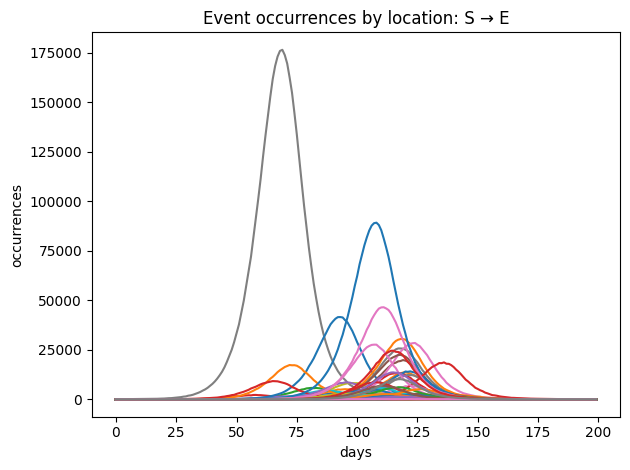

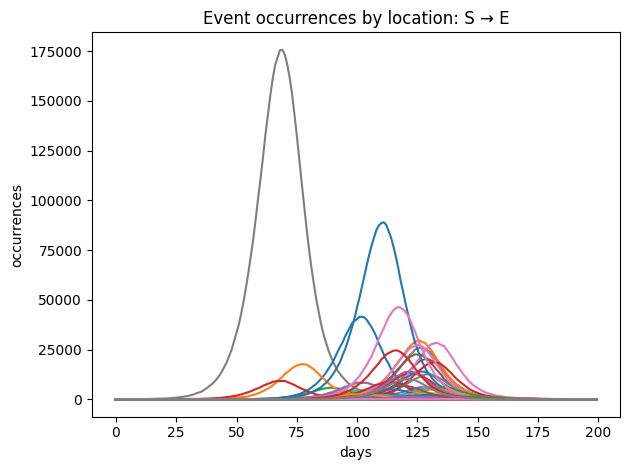

In [5]:
from functools import partial

import numpy as np

import epymorph.initializer as init
from epymorph import *

sim = StandardSimulation(
    geo=my_geo,
    ipm=z_virus_ipm(),
    mm=commuter_mm,
    params={
        'alpha': 0,
        'beta': 0.4,
        'sigma': 1 / 3,
        'gamma': 1 / 9,
        'movement_factor': 1,
    },
    time_frame=TimeFrame.of("2020-04-01", 200),
    initializer=partial(init.indexed_locations,
                        selection=np.array([3, 7, 13]), seed_size=100),
)

with sim_messaging(sim):
    out1 = sim.run()

sim = StandardSimulation(
    geo=my_geo,
    ipm=z_virus_ipm(),
    mm=commuter_mm,
    params={
        'alpha': 0,
        'beta': 0.4,
        'sigma': 1 / 3,
        'gamma': 1 / 9,
        'movement_factor': 0.5,
    },
    time_frame=TimeFrame.of("2020-04-01", 200),
    initializer=partial(init.indexed_locations,
                        selection=np.array([3, 7, 13]), seed_size=100),
)

with sim_messaging(sim):
    out = sim.run()

plot_event(out1, 0)
plot_event(out, 0)

In [6]:
from multiprocessing import Pool

from epymorph.engine.standard_sim import Output


def experiment(alpha: float = 0, movement_factor: float = 1) -> Output:
    sim = StandardSimulation(
        geo=my_geo,
        ipm=z_virus_ipm(),
        mm=commuter_mm,
        params={
            'alpha': alpha,
            'beta': 0.4,
            'sigma': 1 / 3,
            'gamma': 1 / 9,
            'movement_factor': movement_factor,
        },
        time_frame=TimeFrame.of("2020-04-01", 200),
        initializer=partial(init.indexed_locations,
                            selection=np.array([3, 7, 13]), seed_size=100),
    )
    # with sim_messaging(sim):
    return sim.run()


# out_mv_hi = experiment(movement_factor=1)
# out_mv_md = experiment(movement_factor=0.5)
# out_mv_lo = experiment(movement_factor=0.01)
# out_al_lo = experiment(alpha=1)
# out_al_md = experiment(alpha=100)
# out_al_hi = experiment(alpha=1000)


with Pool() as pool:
    results = pool.starmap(experiment, [
        # (alpha, movement_factor)
        (0, 1),
        (0, 0.5),
        (0, 0.01),
        (1, 1),
        (100, 1),
        (1000, 1),
    ])


[out_mv_hi, out_mv_md, out_mv_lo, out_al_lo, out_al_md, out_al_hi] = results

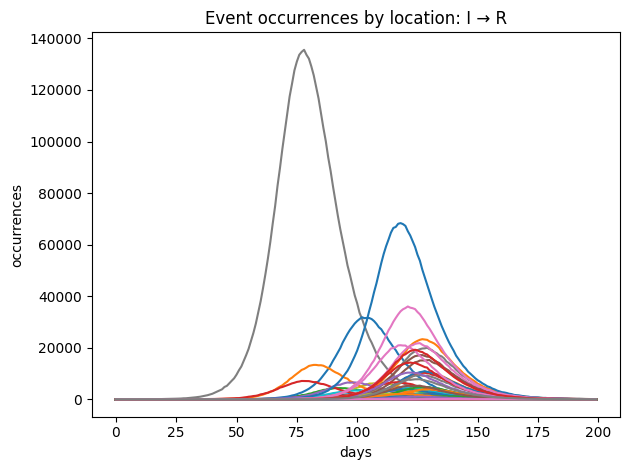

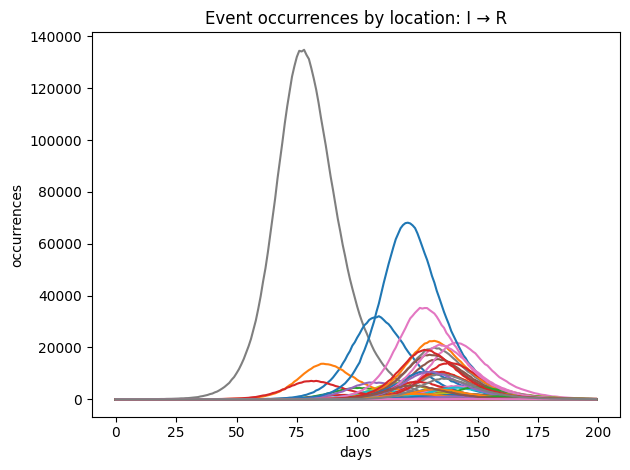

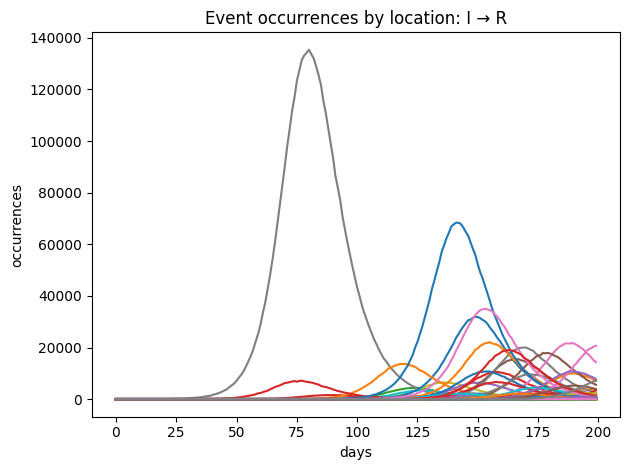

In [7]:
plot_event(out_mv_hi, 2)
plot_event(out_mv_md, 2)
plot_event(out_mv_lo, 2)

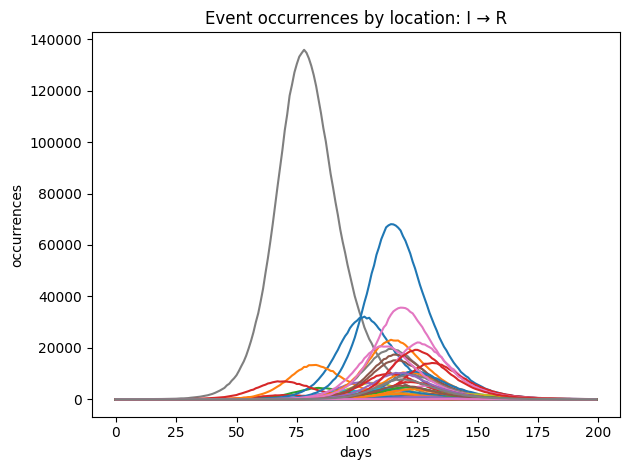

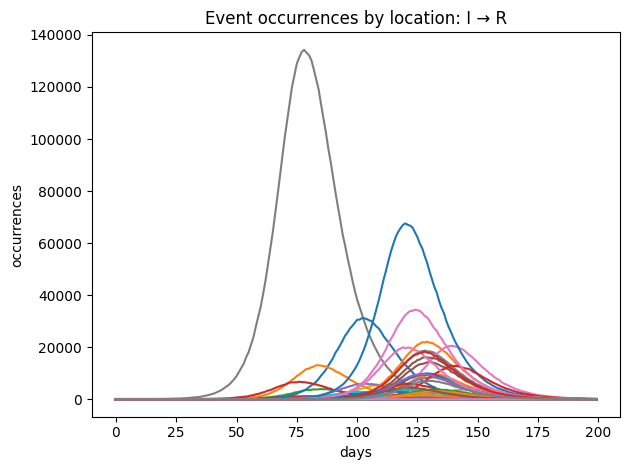

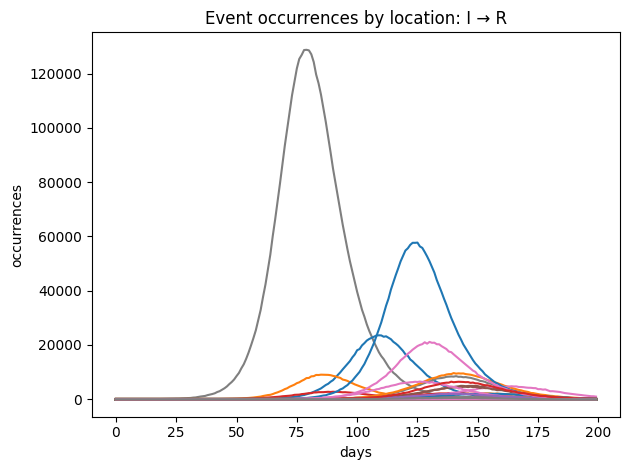

In [8]:
plot_event(out_al_lo, 2)
plot_event(out_al_md, 2)
plot_event(out_al_hi, 2)

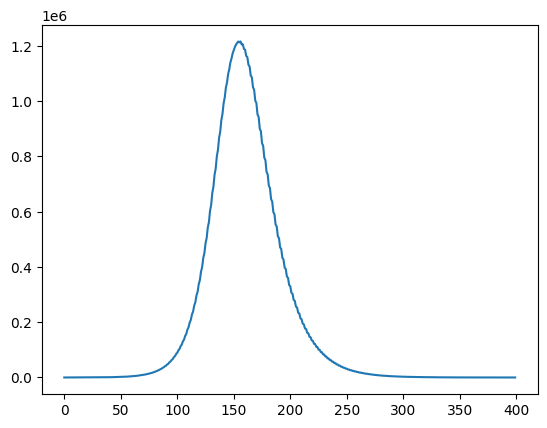

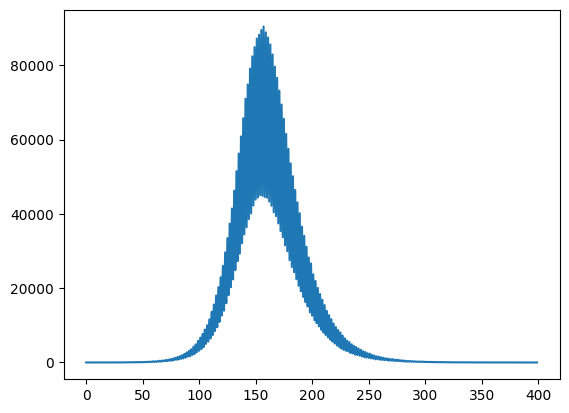

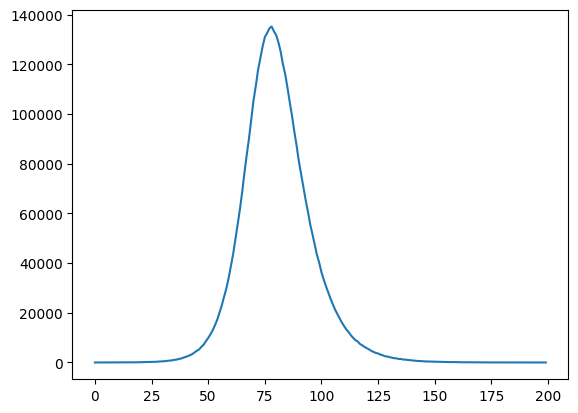

In [9]:
import matplotlib.pyplot as plt

plt.plot(
    np.arange(out.dim.ticks),
    out.prevalence[:, 7, 2],
)
plt.show()
plt.plot(
    np.arange(out.dim.ticks),
    out.incidence[:, 7, 2],
)
plt.show()
plt.plot(
    np.arange(out.dim.days),
    out.incidence_per_day[:, 7, 2],
)
plt.show()

In [10]:
out.incidence[:, :, 2].sum()  # total infections
out.incidence[:, :, 2].sum(axis=0)  # total infections by county
out.incidence_per_day[:, :, 2].max(axis=0)  # peak infection value by county
out.incidence_per_day[:, :, 2].argmax(axis=0)  # day of peak infection by county
out.prevalence[:, :, 2].max(axis=0)  # peak infected value by county
out.prevalence[:, :, 2].argmax(axis=0)  # day of peak infected by county

array([221, 229, 195, 197, 227, 228, 222, 156, 221, 213, 221, 171, 213,
       153, 221, 275, 266, 271, 277, 325, 357, 264, 274, 287, 298, 269,
       285, 299, 321, 303, 285, 270, 267, 263, 251, 279, 283, 297, 271,
       276, 297, 249, 276, 311, 312, 267, 350, 310, 269, 235, 271, 275,
       306, 293, 273, 273, 301, 267, 281, 294, 321, 275, 249, 311, 244,
       335, 285, 318, 251, 296, 221, 270, 252, 330, 274, 267, 237, 275,
       268, 247, 238, 295, 263, 266, 268, 304, 283, 272, 283, 295, 229,
       309, 290, 282, 228, 286, 268, 242, 297, 247, 315, 290, 319, 245,
       270, 275, 326, 299, 239, 265, 297, 292, 261, 237, 313, 271, 319,
       299, 285, 279, 245, 321, 287, 289, 255, 313, 291, 336, 281, 277,
       275, 283, 301, 375, 261, 297, 279, 299, 278, 237, 255, 228, 289,
       275, 311, 308, 252, 253, 277, 282, 266, 219, 315, 249, 269, 254,
       292, 259])

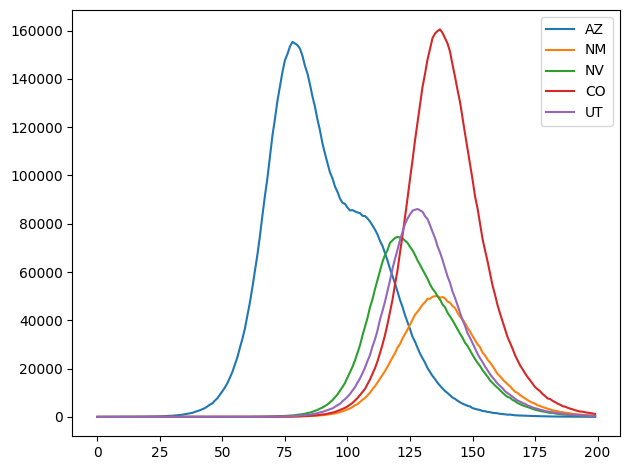

In [11]:
az_cs_idx = np.argwhere(
    np.char.startswith(my_geo['geoid'], '04')
).flatten()

nm_cs_idx = np.argwhere(
    np.char.startswith(my_geo['geoid'], '35')
).flatten()

nv_cs_idx = np.argwhere(
    np.char.startswith(my_geo['geoid'], '32')
).flatten()

co_cs_idx = np.argwhere(
    np.char.startswith(my_geo['geoid'], '08')
).flatten()

ut_cs_idx = np.argwhere(
    np.char.startswith(my_geo['geoid'], '49')
).flatten()

arr = np.column_stack([
    out.incidence_per_day[:, az_cs_idx, 2].sum(axis=1),
    out.incidence_per_day[:, nm_cs_idx, 2].sum(axis=1),
    out.incidence_per_day[:, nv_cs_idx, 2].sum(axis=1),
    out.incidence_per_day[:, co_cs_idx, 2].sum(axis=1),
    out.incidence_per_day[:, ut_cs_idx, 2].sum(axis=1),
])

fig, ax = plt.subplots()
x_axis = np.arange(out.dim.days)
ax.plot(x_axis, arr, label=['AZ', 'NM', 'NV', 'CO', 'UT'])
ax.legend()
fig.tight_layout()
plt.show()

Running simulation (StandardSimulation):
• 2020-04-01 to 2020-10-18 (200 days)
• 158 geo nodes
|####################| 100% 
Runtime: 5.391s


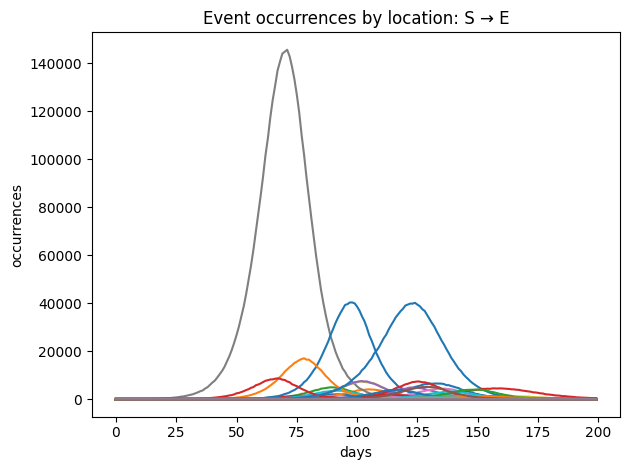

In [12]:
from epymorph.proxy import geo

# this will initially fail with a "unable to adapt shape" if the IPM is still expecting a Scalar alpha


def vaccine_distribution(_, n):
    density = geo['pop_density_km2'][n]
    if density > 100:
        return 5000.0
    else:
        return 100.0


sim = StandardSimulation(
    geo=my_geo,
    ipm=z_virus_ipm(),
    mm=commuter_mm,
    params={
        'alpha': vaccine_distribution,
        'beta': 0.4,
        'sigma': 1 / 3,
        'gamma': 1 / 9,
        'movement_factor': 0.5,
    },
    time_frame=TimeFrame.of("2020-04-01", 200),
    initializer=partial(init.indexed_locations,
                        selection=np.array([3, 7, 13]), seed_size=100),
)

with sim_messaging(sim):
    out = sim.run()

plot_event(out, 0)

In [13]:
out.prevalence[350:370, 7, 4]

array([638757, 637311, 639070, 637311, 638925, 637311, 638757, 637311,
       638897, 637311, 638773, 637311, 638785, 637311, 638771, 637311,
       638787, 637311, 638858, 637311])

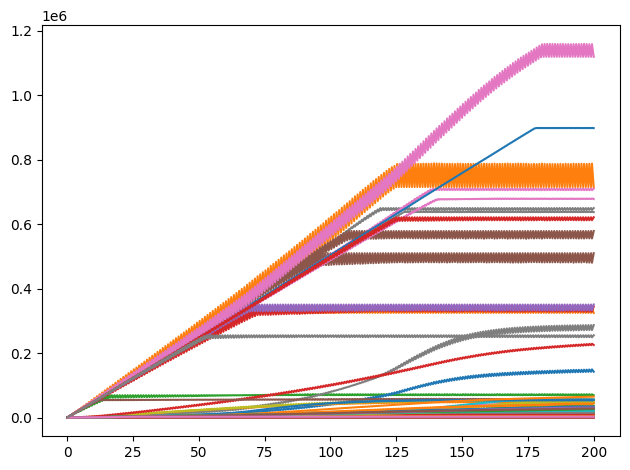

In [14]:
fig, ax = plt.subplots()
x_axis = out.ticks_in_days[:]
y_axis = out.prevalence[:, :, 4]
# x_axis = out.ticks_in_days[0:50]
# y_axis = out.prevalence[0:50, :, 4]
ax.plot(x_axis, y_axis)
fig.tight_layout()
plt.show()

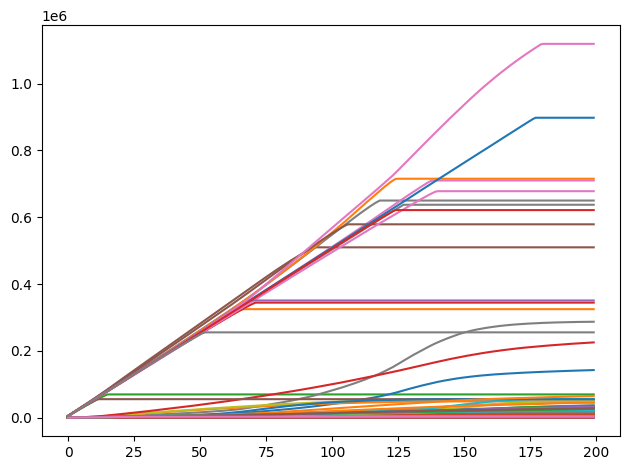

In [15]:
T, N, C, E = out.dim.TNCE
taus = out.dim.tau_steps

fig, ax = plt.subplots()
x_axis = np.arange(out.dim.days)
y_axis = out.prevalence.reshape((T // taus, taus, N, C))[:, 1, :, 4]
ax.plot(x_axis, y_axis)
fig.tight_layout()
plt.show()